# NMT: Seq2Seq model with attention between encoder and decoder, with bidirectional GRU as encoder and GRU as decoder

- Почему GRU?
  - Если посмотреть на распределение длин предложений, то видно что основная масса содержит ±20 токенов. Кажется что LSTM -- overkill

- Bidirectional encoder:
  - hidden_state энкодера имеет размерность 2*hidden_dim, при передачи его декодеру пропускаем через линейный слой -- получаем размерность hidden_dim, затем через tanh 

- Attention mechanism:
  - на каждом шаге считаем аттеншн скоры между всеми состояниями энкодера и предыдущим состоянием декодера, усредняем состояния энкодера с этими весами и получаем вектор W
  - затем на вход блоку GRU приходит concat([embedding, W])
  - дальше по concat([GRU_output, W, embedding]) считаются логиты следующего токена

In [51]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip install nltk
! pip install torchtext

In [52]:
!nvidia-smi

Sun Nov  7 02:07:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    36W / 250W |  14391MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import os
import sys
dir_path = '/content/drive/MyDrive/lab01_nlp'
path_do_data = f'{dir_path}/data.txt'
sys.path.append('/content/drive/MyDrive/lab01_nlp')

In [55]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import numpy as np
import pandas as pd
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer

### Preprocessing:

In [57]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [58]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [59]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [60]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [61]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [62]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9191
Unique tokens in target (en) vocabulary: 6685


Here are tokens from original (RU) corpus:

In [63]:
SRC.vocab.itos[::1000]

['<unk>',
 'sea',
 'ручной',
 'купания',
 'casale',
 '+',
 'premiere',
 'чтения',
 'здорового',
 'улциня']

And from target (EN) corpus:

In [64]:
TRG.vocab.itos[::1000]

['<unk>', 'facing', 'infinity', 'cortina', 'opened', 'solomos', 'mandarin']

And here is example from train dataset:

In [65]:
print(vars(train_data.examples[9]))

{'trg': ['guests', 'can', 'access', 'a', 'shared', 'kitchen', '.'], 'src': ['также', 'в', 'распоряжении', 'гостей', 'общая', 'кухня', '.']}


Let's check the length distributions:

Length distribution in Train data


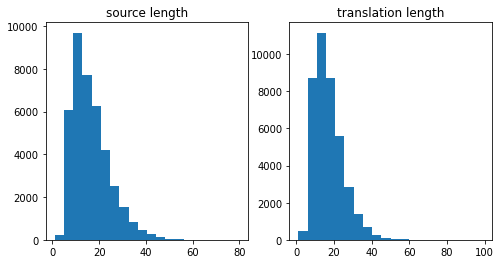

In [66]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


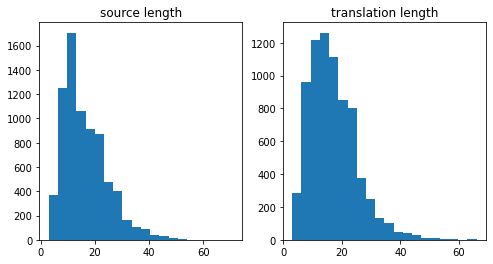

In [67]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model training and evaluation


In [68]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [69]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [70]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [72]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [73]:
%autoreload 2
import my_network
Encoder = my_network.GRUEncoder
Decoder = my_network.GRUAttentionDecoder
Attention = my_network.Attention
Seq2SeqWAttention = my_network.AttentionSeq2Seq

In [74]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

In [75]:
enc = Encoder(
    input_dim=INPUT_DIM,
    emb_dim=ENC_EMB_DIM, 
    enc_hid_dim=HID_DIM, 
    dec_hid_dim=HID_DIM,
    dropout=ENC_DROPOUT
)
attention = Attention(
    enc_hid_dim=HID_DIM,
    dec_hid_dim=HID_DIM
)
dec = Decoder(
    output_dim=OUTPUT_DIM,
    emb_dim=DEC_EMB_DIM, 
    enc_hid_dim=HID_DIM, 
    dec_hid_dim=HID_DIM, 
    dropout=DEC_DROPOUT,
    attention=attention
)

# dont forget to put the model to the right device
model = Seq2SeqWAttention(enc, dec, device)
model.to(device)

AttentionSeq2Seq(
  (encoder): GRUEncoder(
    (embedding): Embedding(9191, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): GRUAttentionDecoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(6685, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=6685, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [76]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

AttentionSeq2Seq(
  (encoder): GRUEncoder(
    (embedding): Embedding(9191, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): GRUAttentionDecoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(6685, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=6685, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [77]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 22,483,741 trainable parameters


In [78]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

In [79]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

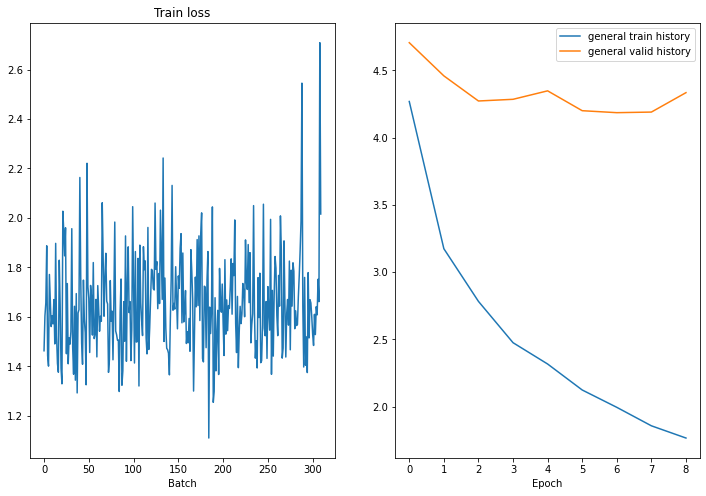

Epoch: 10 | Time: 3m 0s
	Train Loss: 1.655 | Train PPL:   5.232
	 Val. Loss: 4.403 |  Val. PPL:  81.735


In [80]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    scheduler.step(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f'{dir_path}/tut2-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [81]:
model.load_state_dict(torch.load(f'{dir_path}/tut2-model.pt'))
model.eval()

AttentionSeq2Seq(
  (encoder): GRUEncoder(
    (embedding): Embedding(9191, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): GRUAttentionDecoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(6685, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=6685, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

__Let's take a look at our network quality__:

In [82]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [83]:
batch = next(iter(test_iterator))

In [84]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: free wi - fi is included .
Generated: free wifi access is available . this property .

Original: you will find a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .



In [85]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

59it [00:06,  8.87it/s]


In [86]:
from nltk.translate.bleu_score import corpus_bleu
corpus_bleu([[text] for text in original_text], generated_text) * 100

31.307486739109553

получили большой bleu, используя лишь attention между encoder'ом и decoder'ом
